ECE:5450 Machine Learning
Project Part 1
Ryan McDaniel

High Level Overview:



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import platform
import pickle
import get_data as gd

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'text.color': "white"})
plt.rcParams['figure.figsize'] = [24, 6]
plt.rcParams['axes.facecolor'] = 'black'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extract Features from Entire Dataset

In [2]:
import get_features as gf
from skimage import color, filters
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler

def extract(data):
    ret = np.zeros((len(data), 5120))

    greys = np.zeros((len(data), 1024))
    fft_sobels = np.zeros((len(data), 1024))
    hogs = np.zeros((len(data), 2048))
    sobels = np.zeros((len(data), 1024))

    for i in range(len(data)):
        original = gf.toImage(data[i])
        grey = color.rgb2grey(original)
        hsv = color.rgb2hsv(original)
        h, s, v = gf.toComps(hsv)

        f_sobels = gf.toFeatures(filters.sobel(v))
        f_grey = gf.toFeatures(grey)
        f_fft_sobel = gf.toFeatures(gf.FFT_SOBEL(s))
        f_hog = hog(grey, orientations=8, pixels_per_cell=(2, 2),
                    cells_per_block=(1, 1), feature_vector = True)

        greys[i] = f_grey
        fft_sobels[i] = f_fft_sobel
        hogs[i] = f_hog
        sobels[i] = f_sobels

    greys = gf.normalize(greys)
    fft_sobels = gf.normalize(fft_sobels)
    hogs = gf.normalize(hogs)
    sobels = gf.normalize(sobels)

    return np.concatenate((greys, fft_sobels, hogs, sobels), axis = 1).astype(np.float32)

x_train, y_train, x_val, y_val, x_test, y_test = gd.get_CIFAR10_data()

%time x_train_features = extract(x_train[:1000])
print(x_train_features[0])
%time x_val_features = extract(x_val)
%time x_test_features = extract(x_test[:1000])



print(x_train_features.shape)
print(x_val_features.shape)




Wall time: 6.58 s
[0.00044268 0.00032635 0.00034634 ... 0.00089466 0.00207303 0.00098456]
Wall time: 6.57 s
Wall time: 6.56 s
(1000, 5120)
(1000, 5120)


Validation Set Grid Search

In [3]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=600, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
%time grid.fit(x_val_features, y_val)
print(grid.best_params_)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

{'svc__C': 1, 'svc__gamma': 0.0001}


Develop Model on Training Data

In [4]:
# Reduce dimension of non validation sets
x_train_PCA = pca.fit_transform(x_train_features)
x_test_PCA = pca.fit_transform(x_test_features)

svc = SVC(kernel='rbf', class_weight='balanced', C = grid.best_params_['svc__C'], gamma = grid.best_params_['svc__gamma'])
%time model = model.fit(x_train_PCA, y_train[:10000])

%time y_fit = model.predict(x_test_PCA)
np.shape(model)

Wall time: 1min 36s
Wall time: 52.6 s


(2,)

Evaluate Model

Text(699.0200000000001, 0.5, 'predicted label')

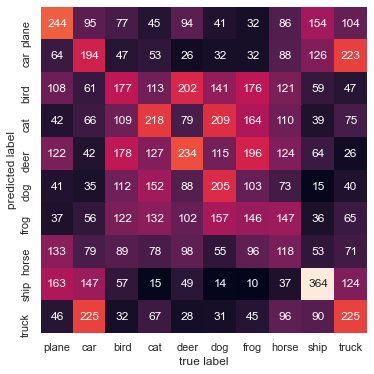

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_fit,
                            target_names=classes))

precision    recall  f1-score   support

       plane       0.25      0.24      0.25      1000
         car       0.22      0.19      0.21      1000
        bird       0.15      0.18      0.16      1000
         cat       0.20      0.22      0.21      1000
        deer       0.19      0.23      0.21      1000
         dog       0.24      0.20      0.22      1000
        frog       0.15      0.15      0.15      1000
       horse       0.14      0.12      0.13      1000
        ship       0.37      0.36      0.37      1000
       truck       0.25      0.23      0.24      1000

    accuracy                           0.21     10000
   macro avg       0.21      0.21      0.21     10000
weighted avg       0.21      0.21      0.21     10000

